# Hypothesis testing, composite case

*Author: Jose A. Hernando, X. Cid Vidal*, February 2026

*Instituto Galego de Altas Enerxías. Universidade de Santiago de Compostela, Spain.*


[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/xabiercidvidal/USC-TA/master)

In [1]:
import time

print( ' Last Execution ', time.asctime())

 Last Execution  Sat Feb  7 22:36:37 2026


In [2]:
# general imports
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# numpy and matplotlib
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as optimize

# possible styles: ggplot (simplicity), bmh (scientify data), 
plt.style.context('seaborn-colorblind')

import htcore     as htcore
import httoys     as httoys
import htcatalog  as htcata
import htplot     as htplot
import htcomposite_examples as htexam
import htintro_examples  as htexam0

# ploting images
from IPython.display import display, Image

## Introduction

In this chapter we will discuss two related issues.

How extreme is a measurement $x$ with respect to a given parameter $\mu$, assuming we know $g(x |\mu)$?

*The response was given by FC!*

In case there is a null hypothesis, $H_0$, and a continuous alternative hypotehesis $H_\mu$, which dependes on $\mu$, ususally if $\mu = 0$ then we recover $H_0$. When we decide if we discover $H_\mu$, which is the CI that we set or exclude for $H_\mu$?

*Again the answer to this question is based on the FC formulation!*

We know that FC provides the method to compute the CI, but sometimes it requires **large computation simulations**. 

But we will see that there are cases where Wilks' theorem allows us to treat the problem with **an analitic approximation.**

## Profile likelihood scan

We try to solve the question: Given a measurement $x$, which is the CI that we set on a parameter $\mu$, knowing the pdf $g(x|\mu)$?

Let's first consider a simple example. The measurement follows a normal gaussian distribution with true $\mu=0$ and sigma unity. 


In [3]:
def plt_ci_interval_gaussian(mu_true = 0, nsigma = 1):
    x0 = stats.norm.rvs(size = 1, loc = mu_true)
    mu_lower = x0 - nsigma
    mu_upper = x0 + nsigma
    xs = np.arange(-6, +6, 0.01)
    htrue  = stats.norm.pdf(xs, loc = mu_true)
    hlower = stats.norm.pdf(xs, loc = mu_lower)
    hupper = stats.norm.pdf(xs, loc = mu_upper)
    plt.plot(xs, htrue, color = 'black', linestyle = 'dashed', label = "true")
    plt.plot(xs, hlower, color = 'red', label = "lower")
    sel = np.logical_and(xs >= mu_lower - nsigma, xs <= mu_lower + nsigma)
    plt.fill_between(xs[sel], 0., hlower[sel], color = 'red', alpha = 0.3);
    plt.plot(xs, hupper, color = 'green', label = "upper")
    sel = np.logical_and(xs >= mu_upper - nsigma, xs <= mu_upper + nsigma)
    plt.fill_between(xs[sel], 0., hupper[sel], color = 'green', alpha = 0.3);
    plt.plot(xs, 0.*np.arange(len(xs)), color = 'black')
    plt.scatter(x0, 0, marker = "*", s = 100)
    plt.plot((x0, x0), (np.array([0.]), stats.norm.pdf(x0, loc = mu_lower)), color = 'blue', linestyle = 'dashed'); 
    plt.scatter(mu_lower, 0, marker = "<", s = 100)
    plt.scatter(mu_upper, 0, marker = ">", s = 100)
    plt.xlabel(r'$\mu$ or $x$')
    plt.grid();
    plt.legend();
    return


The figure shows the measurement, $x$, in the horizontal axis, (the star) and the gaussian pdf associated to the true mean.

In addition there are two other gaussian associated to normal pdfs with means $\mu = x\pm \sigma$. 

Note that these are the two possible gaussians that we can locate farther away with respect our measurement that fulfill the condition that $x_0$ is still in the 68% center contaiment of the gaussian. 

In one case, for $\mu = x + \sigma$, in the left border, and in the other, with $\mu = x-\mu$ in the right border.

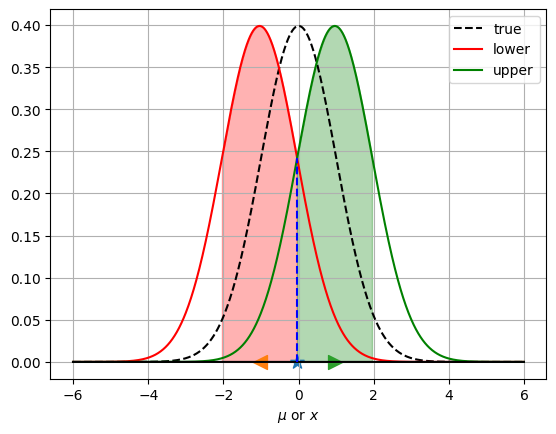

In [4]:
plt_ci_interval_gaussian()

Therefore, given a unique measurement, the best-estimate $\hat{\mu} = x$, and the CI at 68% CL is $[x-\sigma, x+\sigma]$

Let's recuperate the question in a general way:

**How extreme** a data point $x$ is with respect to a given hypothesis $\mu$?

FC have already quantified that answer: We need to compute the distance:

$$
t_\mu( x) = -2 \ln \, \frac{ \mathcal{L}( x \, | \mu)}{ \mathcal{L}( x \, | \, \hat{\mu}( x))}
$$

Low values, close to zero, of $t_\mu(x)$ indicate "good" data. Large values of $t_\mu(x)$ indicate extreme data.

But we need to know the pdf of the distance $t_\mu$, that is $g(t_\mu | \mu)$, in order to compute the p-value of a given measurement $x$, which has an associated distance $t_\mu(x)$.


Note that:

$$
t_\mu(x) = -2 \log \mathcal{L}(x | \mu) + 2 \log \mathcal{L}(x | \hat{\mu}(x))
$$

is a function of $\mu$, and it corresponds to the diference between the *minimum* $-2\log \mathcal{L}(x|\hat{\mu}(x))$ and $-2\log\mathcal{L}(x|\mu)$ at $\mu$.


Now, given a measurement $x$ we estimate $\hat{\mu}(x)$ as the maximum of the $\mathcal{L}(x | \hat{\mu})$.

<table style="border: 1px solid black; border-collapse: collapse;">
    <tr>
        <td style="border: 1px solid black; padding: 8px;font-size: 14px;">And the values of $t_\mu(x)$, scanning along $\mu$, is the <b>profile likelihood scan</b>.</td>
    </tr>
</table>


Remember the example of the likelihood in the introduction chapter!

mu mean : -0.49291716371921607 , mu std : 1.0


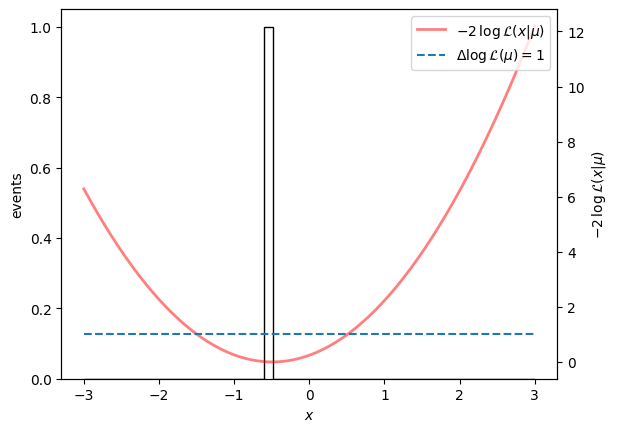

In [5]:
nsize = 1
xs = stats.norm(0., 1.).rvs(nsize)
htexam0.normal_likelihood(xs);
#plt.yscale('log');

In the example of the gaussian above:

We measure one value $x$ obtained as a random value from a normal gaussian, then $\hat{\mu}(x) = x$. 

As there is only one data value, the likelihood is just the gaussian and we have:

$$
t_\mu (x) = -2 \log \mathcal{L}(x | \mu) + 2 \log \mathcal{L}(x | \hat{\mu}(x)) = \frac{(x-\mu)^2}{\sigma^2}
$$

For a given $\mu$, this expression is, by construction, the $\chi^2(n = 1)$, for 1 dof (the degrees of $\mu$).

Notice that the values of $x$ are gaussianly distributed with mean $\mu$ and $\sigma$, therefore its normalized squared distance to the mean, $(x-\mu)^2/\sigma^2$, follows a $\chi^2(1)$ distribution!

Therefore the pdf of $t_\mu(x)$ is the $\chi^2(1)$, a function which has tabulated p-values for each $t_\mu(x)$


For example, for 68 % containment, the values of $x$ should be at a distance equal or less than one sigma, therefore $t_\mu \le 1$. This is, the values of the 68% CL CI are obtained when $t_\mu(x) = 1$

In fact, if $x = \mu \pm \sigma$, the value $(x-\mu)^2/\sigma^2 = 1$


Given $\mu$, the value of $x' \to t'_\mu$ that limits the 68% containment if

$$
\int_0^{t'_\mu} g(t_\mu | \mu) \, \mathrm{d} t_\mu = \int_0^{1} \chi^2(t | n = 1) \, \mathrm{d}t = 0.68 \, \Rightarrow \, t_\mu = 1
$$

In this example of the gaussian, given a measurement $x$, to get the 68% cover interval we scan $\mu$ till we get $t_\mu = 1$! 

<table style="border: 1px solid black; border-collapse: collapse;">
    <tr>
        <td style="border: 1px solid black; padding: 8px;font-size: 14px;">There is a theorem, <b>Wilks' theorem</b>, which tell us that if our data "follows gaussian statistics", then the $t_\mu(x)$ FC variable is distributed as a $\chi^2(n)$, where $n$ is the number of degrees of freedom of $\mu$.</td>
    </tr>
</table>


In this case, there is a direct connection between the $t_\mu(x)$ that we compute from data $x$, which is the *log likelihood scan* in $\mu$, with a p-value.

In some (many) cases, the approximation that $g(t_\mu | \mu)$ follows a $\chi^2$ can be good enough.




We had used this property in *regression*, when we obtained errors of $\hat{\mu}$ with the maximum likelihood estimation! 

We defined the errors, i.e. the CI at 68% CL, doing the log likelihood scan, and setting the values of the interval when $-2\Delta\log \mathcal{L}$ = 1, that is, the increase of $-2\log\mathcal{L}$ with respect to the minimum value is 1.

In the next example, we are going to test Wilks' theorem with the case with which we started this section, an experiment of measurement $x$, one value, from a normal gaussian distribution.

We fix a value of the mean value of the gaussian, $\mu$, and generate $n$ experiments, for each one we compute $\hat{\mu}$ and $t_\mu(x)$. We obtain the pdf of $t_\mu(x)$, i.e. is the normalized distribution of the $t_\mu(x)$ values of the $n$ experiments, and check if that pdf is the $\chi^2(1)$.

**Example**: Consider a gaussian distribution with mean $\mu=0$ and sigma one. Verify that $t_\mu$ is distributed with a $\chi^2(1)$.


mean muhat :  0.043992750000000067 , std 1.0047932534632447


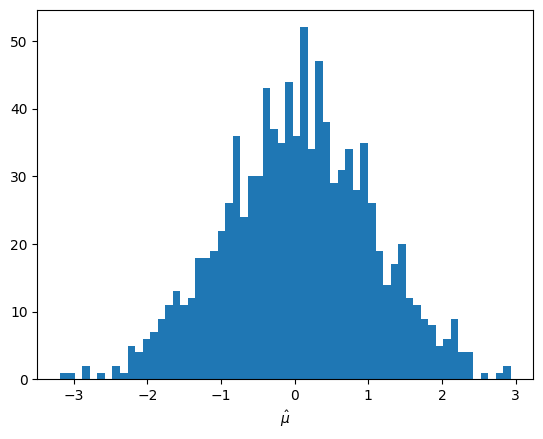

In [26]:
mu, sigma, size  = 0., 1., 1000
par, mask = (mu, sigma), (True, False)
rv        = stats.norm
xs        = rv.rvs(mu, sigma, size = size)
ht        = htcore.htcomposite(rv, par, mask = mask)
muhats    = [float(ht.mubest(xi)[0])  for xi in xs]
tmus      = [ht.tmu(xi, mu)        for xi in xs]
print('mean muhat : ', np.mean(muhats), ', std', np.std(muhats))
plt.hist(muhats, 60); plt.xlabel(r'$\hat{\mu}$');

chi2  1.0143112045170777
p-value mean : 0.5050538046072487 ; std * sqrt(12.) : 1.0161414002538056


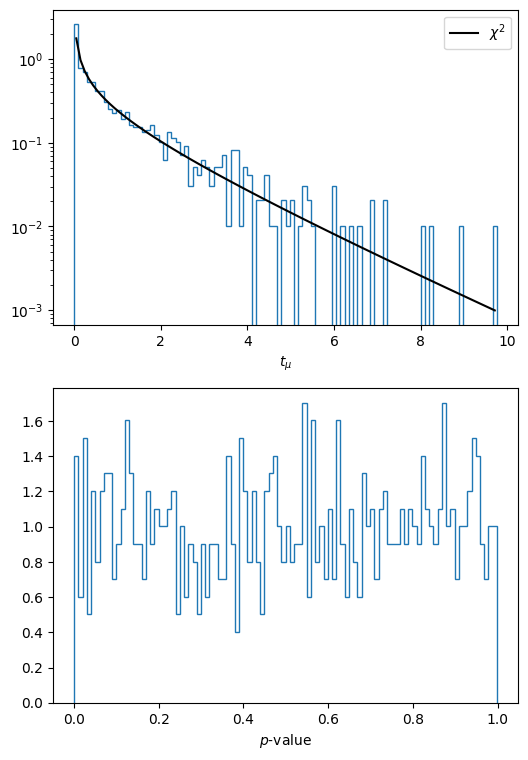

In [7]:
htplot.chi2_test(tmus, nbins = 100, label = r'$t_\mu$')

**Exercise**: Consider the case of a poisson distribution with an unknown mean $\mu$ and the null hypothesis $\mu_0$. Check for which values of $\mu$, $g(t_\mu | \mu)$ follows a $\chi^2(1)$ distribution.

### the p-value

We are back to the construction of a CI of $\mu$ at $\beta$ CL given data $x_0$.

In the "gaussian" regime, when Wilks' theorem applies, we can use the relation between $t_\mu(x)$ and its p-value, $p_\mu$, via the $\chi^2(1)$ distribution. Since the $\chi^2(1)$ distribution with 1 degree of freedom behaves like a squared normal variable 
$( Z^2 \sim \chi^2_1 )$, we can approximate $\sqrt{t_\mu(x)} \approx Z$, where $Z$ follows a standard normal distribution. With this, the $p-$value becomes:

$$
p_\mu = 2 \, [1 - \Phi(\sqrt{t_\mu(x)})]~~{\rm(Eq.~1)}
$$

Where $\Phi(x)$ is the cumulative function of a normal gaussian, and the factor of 2 accounts for a two-sided (or two-tailed) hypothesis test.


We can now:

- define a CI of $\mu$ at $\beta$ CL, for those values for which $p_\mu >= 1-\beta$.

- claim discovery of $H_1(\mu_0)$ when $p_0$ has a Z-value $\ge 5$.

**Example**: Consider a gaussian distribution with fix sigma and unknown $\mu$, and the null hypothesis is $\mu_0$. Generate an observation data, $x$, and compute the CI of $\mu$ at $\beta$ CL using the $t_\mu(x_0)$ variable. Consider $\mu=3$ and $\beta = 0.68$.

In this example, we generate an experiment, where the data $x$ is the value obtained from a gaussian, in that case $\hat{\mu} = x$, we can do the scan likelihood, and obtain $t_\mu(x)$ scanning along $\mu$, and use the $t_\mu(x) \to $ p-value association, to get the function of the p-value depending on $\mu$. 

**Explore**: Change the size of the dataset.

In [8]:
mu, sigma, size = 3., 1., 1
par, mask       = (mu, sigma), (True, False)
rv              = stats.norm
ht              = htcore.htcomposite(rv, par, mask = mask)
x0              = rv.rvs(*par, size = size)
parbest = ht.parbest(x0) 
print('observed data ', x0, ', best par ', parbest)

observed data  [1.71591956] , best par  [1.71591797 1.        ]


mu mean : 1.7159195595943042 , mu std : 1.0


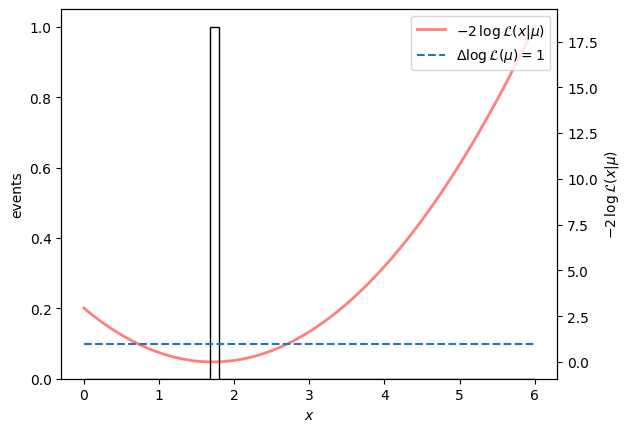

In [9]:
htexam0.normal_likelihood(x0,mus = np.linspace(0., 6., 100));

central CI  : [0.72146168 2.71037744] at  68 % CL


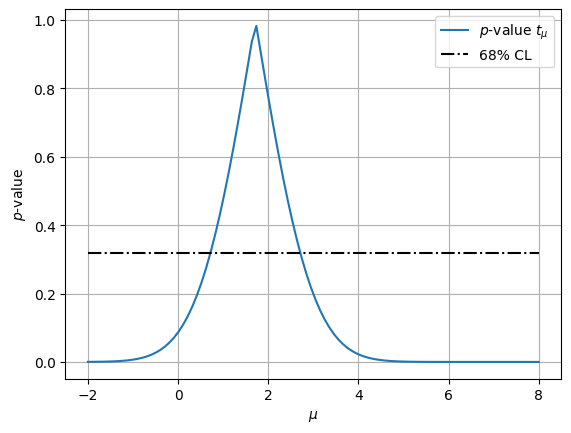

In [10]:
mu0, mu1, nmus, beta = mu-5, mu+5, 100, 0.68
mus   = np.linspace(mu0, mu1, nmus)
tmus  = [ht    .tmu(x0, mui, parbest = parbest) for mui  in mus] ## follow the formula for tmu
ptmus = [htcore.tmu_pvalue(tmui)                for tmui in tmus] ## follow Eq (1)
ci     = ht.tmu_cint(x0, beta = beta)
 
htplot.prt_wilks_pvalues(beta, ci_central = ci)
htplot.plt_wilks_pvalues(beta, mus, ptmus = ptmus);

## Composite testing


Let's return to our initial problem, how to test an alternative hypothesis (a composite one) that depends continuously on a parameter $\mu$, i.e. $H_\mu$, with respect to the default hypothesis $H_0$, where usually $\mu = 0$ implies $H_0$.

See the folowing figure, it considers that $H_0$ is a normal gaussian, and $H_\mu$ a gaussian centered at $\mu$ with sigma 3.

You can explore and chaage $\mu$, get an experiment, a data $x$, and compute the p-values with respect to both hypotheses $H_0$ and $H_\mu$



observed data : [-0.38380109]
H0 p-value    : 0.64943706
H1 p-value    : 0.00035745
CLs           : 0.00101964 


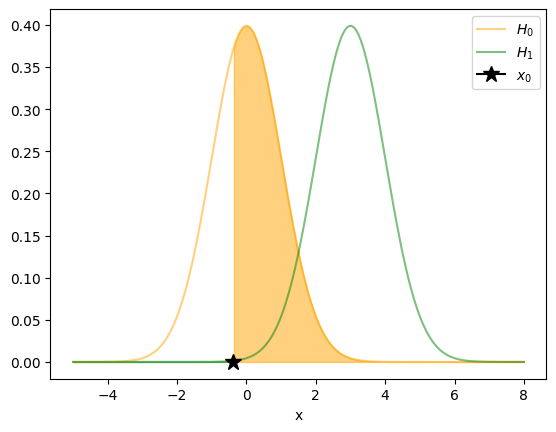

In [11]:
mu = 3.
httoys.gaussian(0., mu, sigma1 = 1.);

In this case, if the true is $\mu = 5$, you expect to claim discovery in 50% of the experiments!

observed data : [5.09082662]
H0 p-value    : 0.00000018
H1 p-value    : 0.53618482
CLs           : 0.53618492 


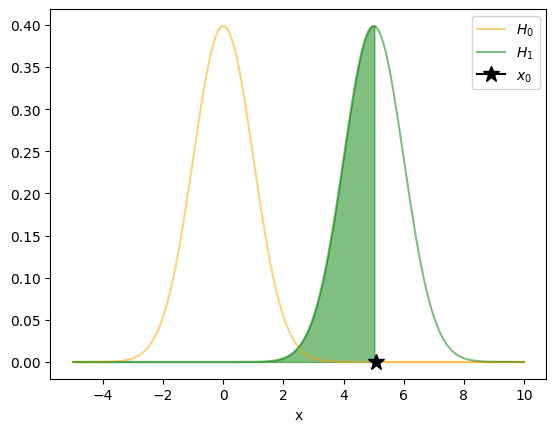

In [12]:
mu = 5.
httoys.gaussian(0., mu, sigma1 = 1., mutrue = True);

As we did with the simple hypothesis we consider two different situations:
    
    
   * Test the null hypothesis, $H_0$, we claim observation if the p-value is equal or smaller than $5Z$
   
   
   * Test the alternative hypothesis. Set a CI to exclude or to cover $\mu$ with $\beta$ usually 90-95% CL. The limit of the interval corresponds to the p-value of $H_\mu$ equal or smaller than $1-\beta$.

We define here the common test-statistics used in HEP to claim discovery or set CI for the strength parameter $\mu$.

### Testing the null-hypothesis

In same cases the strength parameter fulfills $\mu \ge \mu_0$. In consequence, we could say that the values of $\hat{\mu}(x) \lt \mu_0$ do not challenge $H_0$.

We consider that data which prefers $\mu \le \mu_0$ are by definition compatible with $H_0$. 

If we define:

$$
\lambda(\mu) = \frac{\mathcal{L}(x | \mu)}{\mathcal{L}(x | \hat{\mu}(x))}
$$

To check the compatibility with $\mu_0$, we can use:

$$
q_0 = \left\{ \begin{array}{ll}  
-2 \ln \lambda(\mu_0) & \mbox{if $\hat{\mu}(x) > \mu_0$} \\
0 & \mbox{if $\hat{\mu}(x) \le \mu_0$}
\end{array} \right. 
$$ 

For example, in a counting experiment, if a background is $b$ counts, and the strength is $\mu$, that is, our possible signal is $b+\mu$.

If we observe $n \le b$, we consider that the experiment is compatible with $H_0$ by definition. Our experiment did not challenge the $H_0$ hypothesis


Now the pdf, $g(q_0 \, | \mu_0)$, will be a "half" $\chi^2$ distribution. 

In this case there is even a simpler relation with the $p$-value of $H_0$, the *goodness-of-fit* of $H_0$.

$$
p_0 = 1-\Phi(\sqrt{q_0})
$$

That translates directly into number of sigmas, $Z$:

$$
Z = \sqrt{q_0}
$$

**Example**: In the case of a gaussian hypothesis with mean $\mu$ positive and sigma one, and the null hypothesis $\mu_0 = 0$. Generate an observation data for the case $\mu_{true} = 3$ and compute the $p$-value and $Z$-value of $H_0$.

In [13]:
mu0, mutrue, sigma, size = 0., 3., 1., 1
par, mask               = (mutrue, sigma), (True, False)
x0    = stats.norm.rvs(*par, size = size)
ht    = htcore.htcomposite(stats.norm, par, mask = mask)

parbest = ht.parbest(x0)
q0      = ht.q0(x0, mu0)
p0      = htcore.q0_pvalue(q0)

print('x0 ', x0, 'parhat ', parbest)

x0  [3.84210592] parhat  [3.84213867 1.        ]


x0  [3.84210592] parhat  [3.84213867 1.        ]
q0  14.76177792680348 p-value 6.0991584498570894e-05 Z-value 3.8421059234231794
observed data : [3.84210592]
H0 p-value    : 0.00006099
H1 p-value    : 0.12345363
CLs           : 0.12346116 


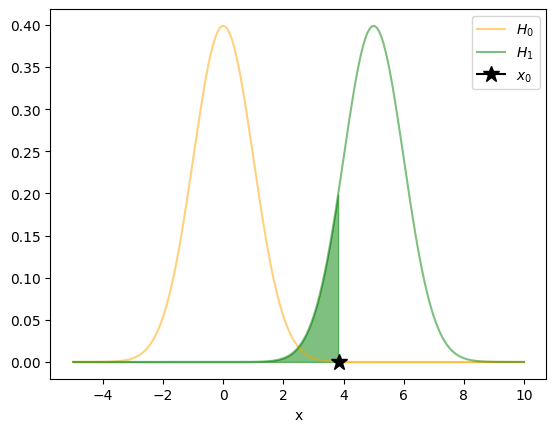

In [14]:
print('x0 ', x0, 'parhat ', parbest)
print('q0 ', q0, 'p-value', p0, 'Z-value', np.sqrt(q0))
httoys.gaussian(mu0, mu, x0 = x0, sigma1 = 1.);

**Exercise** Verify that the $q_0$ distribution is a 'half'-$\chi^2$.

### Testing the alternative hypothesis

To set an **upper** limit on the value of $\mu$, a $\mu$ above $\hat{\mu}$  does not challege the alternative hypothesis.

Given our data $x$, this implies that if $\mu \gt \hat{\mu}(x)$, we accept as valid the alternative hypothesis.

With the likelihood-ratio:

$$
\lambda(\mu) = \frac{\mathcal{L}(x | \mu)}{\mathcal{L}(x | \hat{\mu}(x))}
$$


We can now construct:

$$
q_\mu = \left\{ \begin{array}{ll} 
-2 \ln \lambda(\mu) & \mbox{if $\hat{\mu}(x) \le \mu$} \\
0 & \mbox{if $\hat{\mu}(x) \gt \mu$}
\end{array} \right.
$$



Again the pdf, $g(q_\mu | \mu)$  is a "half" $\chi^2$ distribution.

And computing p-value of the $H_1(\mu)$ hypothesis is very simple:

$$
p_\mu = 1 - \Phi(\sqrt{q_\mu})
$$

This $p_\mu$-value allows us to compute the upper limit on $\mu$ at a given $\beta$ CL.

We will set an upper limit if $H_0$ is not nullified (there is no observation), at the value of $\mu$ such that the p-value of $q_\mu$ is smaller than $\beta = 5, 10$.

If we can claim discovery, we can set a CI, with the best estimate $\hat{\mu}(x)$ and the interval values given by the value of $\mu$ at which the p-value associated with $q_\mu$ is $\beta$.

**Example** Consider a gaussian distributed with mean $\mu_0 = 0$ and sigma 1. Generate an experiment, compute $q_\mu$ for $\mu = 3$. Set the upper limit on $\mu$ at 90% CL.

In [15]:
mu, mutrue, sigma, size, beta = 3., 0., 1., 1, 0.90
par, mask                 = (mutrue, sigma), (True, False)
ht  = htcore.htcomposite(stats.norm, par, mask = mask)
     
x0      = stats.norm.rvs(*par, size = size)
parbest = ht.parbest(x0)
qmu     = ht.qmu(x0, mu)
pqmu    = htcore.qmu_pvalue(qmu)
muup    = ht.qmu_ulim(x0, beta = beta)

print('x0  ', x0 , 'parbest ', parbest);

x0   [0.66546953] parbest  [0.6655 1.    ]


x0   [0.66546953] parbest  [0.6655 1.    ]
qmu  5.450032526295416 p-value  0.009783981191973545  at mu  3.0
upper limit : [1.94702109] at  90 % CL
observed data : [0.66546953]
H0 p-value    : 0.25287511
H1 p-value    : 0.10000000
CLs           : 0.13384643 


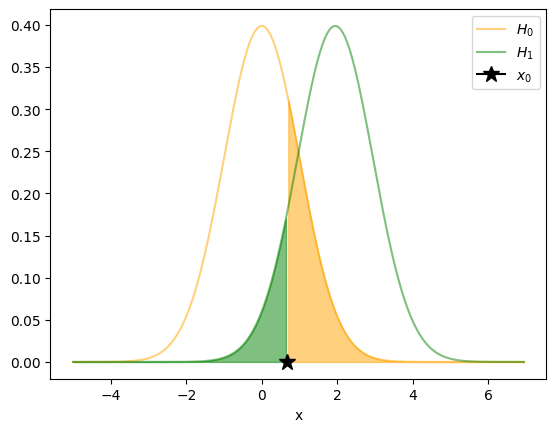

In [16]:
print('x0  ', x0 , 'parbest ', parbest);
print('qmu ', qmu, 'p-value ', pqmu, ' at mu ', mu)
htplot.prt_wilks_pvalues(beta, ci_upper = muup)

httoys.gaussian(mutrue, muup, x0 = x0, sigma1 = sigma);

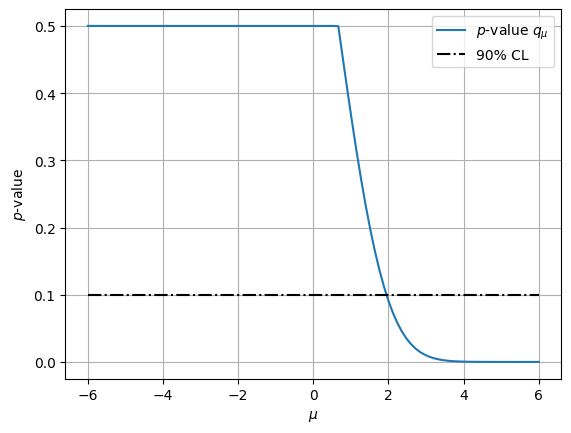

In [17]:
mu0, mu1, nmus = -6., 6., 100
mus    = np.linspace(mu0, mu1, nmus)
qmus   = [ht    .qmu(x0,  mui, parbest = parbest) for mui in mus]
pqmus  = [htcore.qmu_pvalue(qmui)               for qmui in qmus]
htplot.plt_wilks_pvalues(beta, mus, pqmus = pqmus);

**Exercise**: Consider an experiment with a gaussian distribution with mean $\mu$ and sigma 1. Consider $\mu_{true} = \mu_0 = 0$. Obtain the distribution of the upper limits at 90 %CL. 

## Nuisance parameters 

Consider a counting experiment with a control region that is $\tau$ times larger than the signal region. In both regions the expected background events is $\nu$, while in the signal region we expect $\nu + \mu$ events. 

**Explore** in the following toy the generation of some events, with different values of $\nu$, $\mu$.

We are interested on measuring $\mu$ and estimating $\nu$ from the control sample. $\nu$ is a nuisance parameter, how can we treat it?

bkg events : 46 signal events : 5


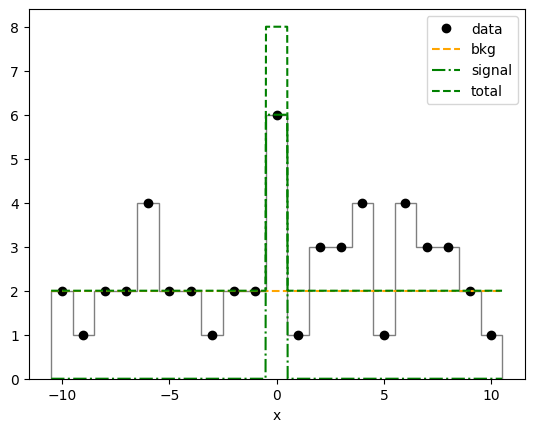

In [18]:
mu, nu, tau = 6, 2, 20
httoys.poisson_control_rvs(mu, nu, tau, tau + 1);


We can extend the likelihood to estimate the nuisance parameter, $\nu$, and use:

$$
t_\mu = -2 \ln \frac{\mathcal{L}(x \, | \mu, \, \hat{\nu}(\mu, x))}{ \mathcal{L}(x \, | \, \hat{\mu}(x), \hat{\nu} (x))}
$$

where $\hat{\nu}(x)$ is the best estimate given $x$, and $\hat{\nu}(\mu, x)$ is the best estimate when fixing $\mu$ and given $x$.


And use the test statistics $q_0$ and $q_\mu$ to test the null and the composite hypotheses and set a CI for $\mu$ using $t_\mu$.

**Example:** Consider an experiment that searches for a signal $\nu+\mu$. The background, $\nu$, is measured in a independent region, called *control* region, where there is no signal, and an expected background $\tau \times \nu$, where $\tau$ is known. Consider $\nu$ as the nuisance parameter. The experiment observes $k$ events in the control and signal regions. Consider an experiment with $k=4$, $\tau = 20$, $\nu = 2$ and $\mu = 6$. What is the range of $\mu$ excluded at 90 %CL. Compute $q_0$, is there a discovery, and observation? 


This is a prototype of a search. The pdf is:

$$
g(n, \, m \, | \, \mu, \, \nu) = \frac{(\nu+\mu )^m \, e^{-(\nu + \mu)}}{m!} \, \frac{(\tau \nu)^n \, e^{-\tau \nu}}{n!}
$$

where $m$ are the events in the signal region and $n$ are the events in the control region. 



**Example**: Generate an observed data, $x_0$, for an experiment with a control and a signal region. The control region follows a poisson with $\tau \nu$, and the signal $\nu + \mu$. Consider the case $\tau = 20$, $\nu = 2$ and $\mu = 6$.

Compute:

a) The p-value with the null hypothesis $\mu=0$.

b) The lower value of the upper CI at 90% using $q_\mu$

c) the central CI at 90% CL using $t_\mu$

Generate an experiment, $x_0$, compute $\hat{\mu}(x_0), \, \hat{\nu}(x_0)$, and $\hat{\nu}(\mu, x_0)$ for a fixed $\mu$.

In [27]:
mu, nu, tau = 6., 2., 20.
par, mask, masknu  = (mu, nu, tau), (True, True, False), (False, True, False)

# generate an observation and obtain the best-estimate of mu, nu and nu given mu
rv      = htcata.poisson_control_signal
x0      = rv.rvs(*par, size =1)[0]
ht      = htcore.htcomposite(rv, par, mask = mask, masknu = masknu) 
parbest = ht.parbest(x0)
nubest  = ht.parmubest(x0, mu)

print('mu, nu true   :', mu, nu)
print('events in control, signal region :', x0[0], x0[1])
print('events in control region/tau     :', x0[0]/tau)
print('par best :', parbest)
print('par best :', nubest, ' fixed mu at ', mu)

mu, nu true   : 6.0 2.0
events in control, signal region : 46.0 7.0
events in control region/tau     : 2.3
par best : [ 4.69997309  2.29999659 20.        ]
par best : [ 6.          2.28232422 20.        ]  fixed mu at  6.0


Compute $t_\mu(x_0)$, $q_0(x_0)$ and $q_\mu(x_0)$ as a function of $\mu$. 

In [20]:
mu0, mu1, nmus = 2., 20., 100
mus    = np.linspace(mu0, mu1, nmus)
q0     = ht.q0(x0, 0.)
tmus   = [ht.tmu      (x0, mi, parbest = parbest) for mi in mus]
qmus   = [ht.qmu      (x0, mi, parbest = parbest) for mi in mus]

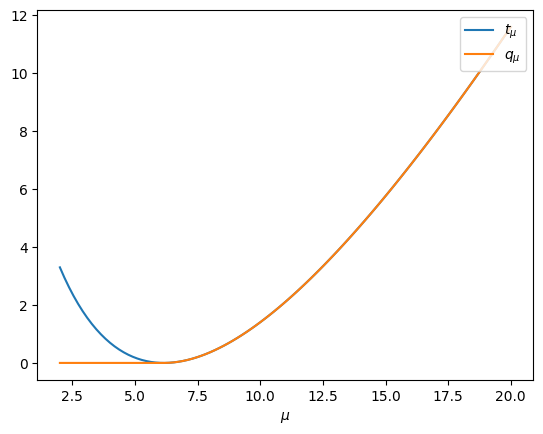

In [21]:
plt.plot(mus, tmus, label = r'$t_\mu$');
plt.plot(mus, qmus, label = r'$q_\mu$');
plt.xlabel(r'$\mu$'); plt.legend(loc = 1);

Compute p-values for $q_0(x_0)$, $t_\mu(x_0)$ and $q_\mu(x_0)$ and set a upper limit and a CI.

In [22]:
# compute the CI using tmu, and upper limit using qmu
beta = 0.90
pts = [htcore.tmu_pvalue(tmu) for tmu in tmus]
pqs = [htcore.qmu_pvalue(qmu) for qmu in qmus]
ci_upper   = ht.qmu_ulim(x0, beta = beta, parbest = parbest);
ci_central = ht.tmu_cint(x0, beta = beta, parbest = parbest);

H0 p-value  0.0007013670865270161 Z-value  3.1940878630121694
upper limit : [10.35739686] at  90 % CL
central CI  : [ 2.30968551 11.76340839] at  90 % CL


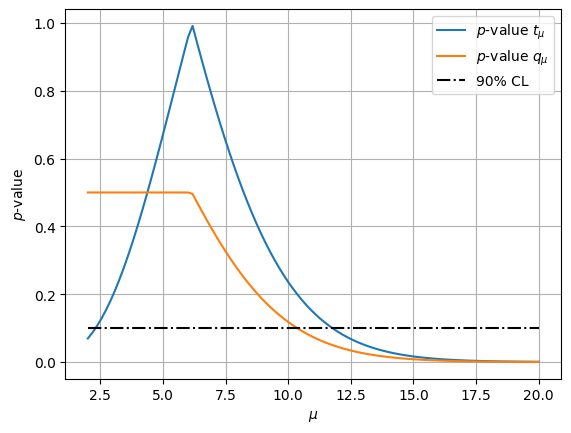

In [23]:
print('H0 p-value ', htcore.q0_pvalue(q0), 'Z-value ', np.sqrt(q0))
htplot.prt_wilks_pvalues(beta, ci_central, ci_upper)
htplot.plt_wilks_pvalues(beta, mus, pts, pqs)

**Example**: Generate now $m$ experiments, and obtain the $\hat{\mu}, \hat{\nu}$ distributions.

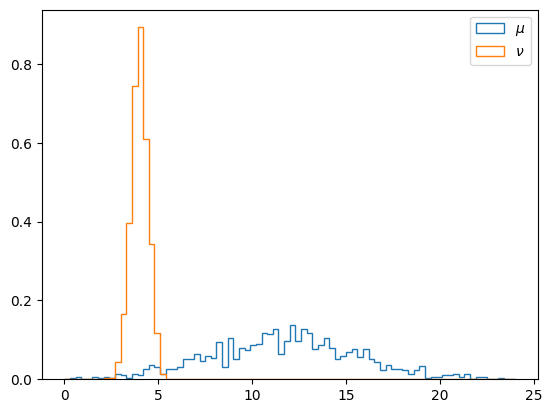

In [24]:
mu, nu, tau, size  = 12., 4., 20., 1000
htexam.poisson_control_muhat_hist(mu, nu, tau, size)

**Example** In the following plot we show the p-value of the an observed data instance $x_0$ in the plane $(\mu, \nu)$. They are computed assuming that $t_\mu(x)$ follows a $\chi^2$ pdf with 2 dof. The * in the plot is the best-estimate point, $(\hat{\mu}(x_0), \hat{\nu}(x_0))$, and the line the best nuisance parameter $\hat{\nu}(\mu, x_0)$ as a funcion of $\mu$. 

data     : (38.0, 17.0)
best par : [13.2  3.8]
central CI : [ 7.18476856 20.97012882]


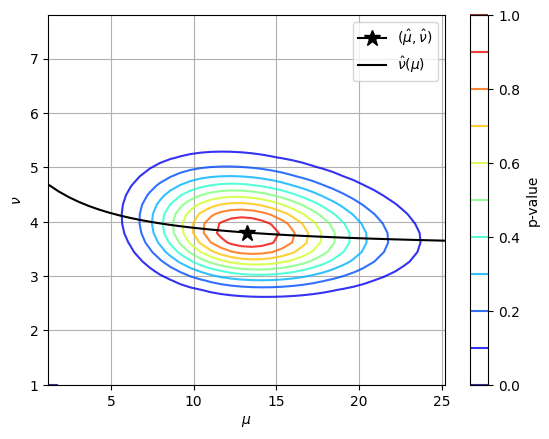

In [25]:
mu, nu, tau = 12., 4., 10.
htexam.poisson_control_ci(mu, nu, tau);

Notice that a p-value 0.1 corresponds to the CI region of 90% CL and the projection onto the $\mu$ axis in the 90% CL for the $\mu$ parameter when $\nu$ is considered a nuisance parameter.